In [142]:
import lib

import itertools
import pprint

from pathlib import Path
from typing import cast

import pandas as pd
import numpy as np
import polars as pl
import plotnine as pn
from scipy.stats import tukey_hsd

import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
})

model_name = {
    'xgboost_': 'XGBoost',
    'catboost_': 'CatBoost',
    'lightgbm_': 'LightGBM',
    'snn': 'SNN',
    'mlp': 'MLP',
    'mlp-plr': 'MLP (PLR)',
    'linfin': 'DFR',
    'resnet': 'ResNet',
    'dcn2': 'DCNv2',
    'ft_transformer': 'FT-Transformer',
    'tabr-causal': 'TabR (causal)',
    'tabr': 'TabR',
    'trompt': 'Trompt',
    'random_forest': 'RandomForest',
    'linear_model': 'Linear Model',
}

datasets = [
    'sberbank-housing',
    'cooking-time',
    'delivery-eta',
    'maps-routing',
    'weather',
    'homesite-insurance',
    'ecom-offers',
    'homecredit-default',
]

dataset_name = {
    'homesite-insurance': 'Homesite Insurance',
    'ecom-offers': 'Ecom Offers',
    'homecredit-default': 'HomeCredit Default',
    'sberbank-housing': 'Sberbank Housing',
    'cooking-time': 'Cooking Time',
    'delivery-eta': 'Delivery ETA',
    'maps-routing': 'Maps Routing',
    'weather': 'Weather',
}

In [116]:
# Load all exps data

data = pl.DataFrame(cast(pd.DataFrame, pd.json_normalize(
    [
        lib.load_json(f) | {
            'model': m, 'split': s, 'split-idx': si, 'data': d,
            'task': 'regression' if d not in ['homesite-insurance', 'homecredit-default', 'ecom-offers'] else 'binclass'
        }
        for m in ["mlp", "mlp-plr", "xgboost_", "tabr"]
        for d in datasets
        for s in ["random", "sliding-window"]
        for si in range(3)
        for f in lib.EXP_DIR.glob(f'temporal-shift-analysis/{m}/{d}-{s}-{si}/evaluation/**/report.json')
    ]
)))

scores = data.select(
    pl.col('model'),
    pl.col('data'),
    pl.col('split'),
    pl.col('split-idx'),
    pl.col('task'),
    pl.col('metrics.test.score').alias('score'),
    pl.col('config.seed').alias('seed'),
)

s = scores.group_by('model', 'data', 'split', 'split-idx').agg(
    pl.col('score').abs().mean(),
    pl.col('score').var().alias('score_var'),
).group_by(
    'model', 'data', 'split'
).agg(
    pl.col('score').mean(),
    pl.col('score_var').mean().sqrt().alias('score_std'),
)
s
# To Plot multiple boxplots at once
# s = scores.group_by('model', 'data', 'split', 'split-idx').agg(
#     pl.col('score').abs()
# )

model,data,split,score,score_std
str,str,str,f64,f64
"""mlp-plr""","""delivery-eta""","""random""",0.533541,0.000165
"""xgboost_""","""sberbank-housi…","""sliding-window…",0.254653,0.00042
"""xgboost_""","""maps-routing""","""random""",0.160459,0.000037
"""mlp""","""homecredit-def…","""sliding-window…",0.836645,0.000968
"""tabr""","""delivery-eta""","""random""",0.536849,0.000305
…,…,…,…,…
"""mlp""","""weather""","""sliding-window…",1.661865,0.007501
"""mlp""","""weather""","""random""",1.504965,0.003554
"""mlp""","""ecom-offers""","""random""",0.696556,0.000742


In [141]:
from matplotlib.lines import Line2D

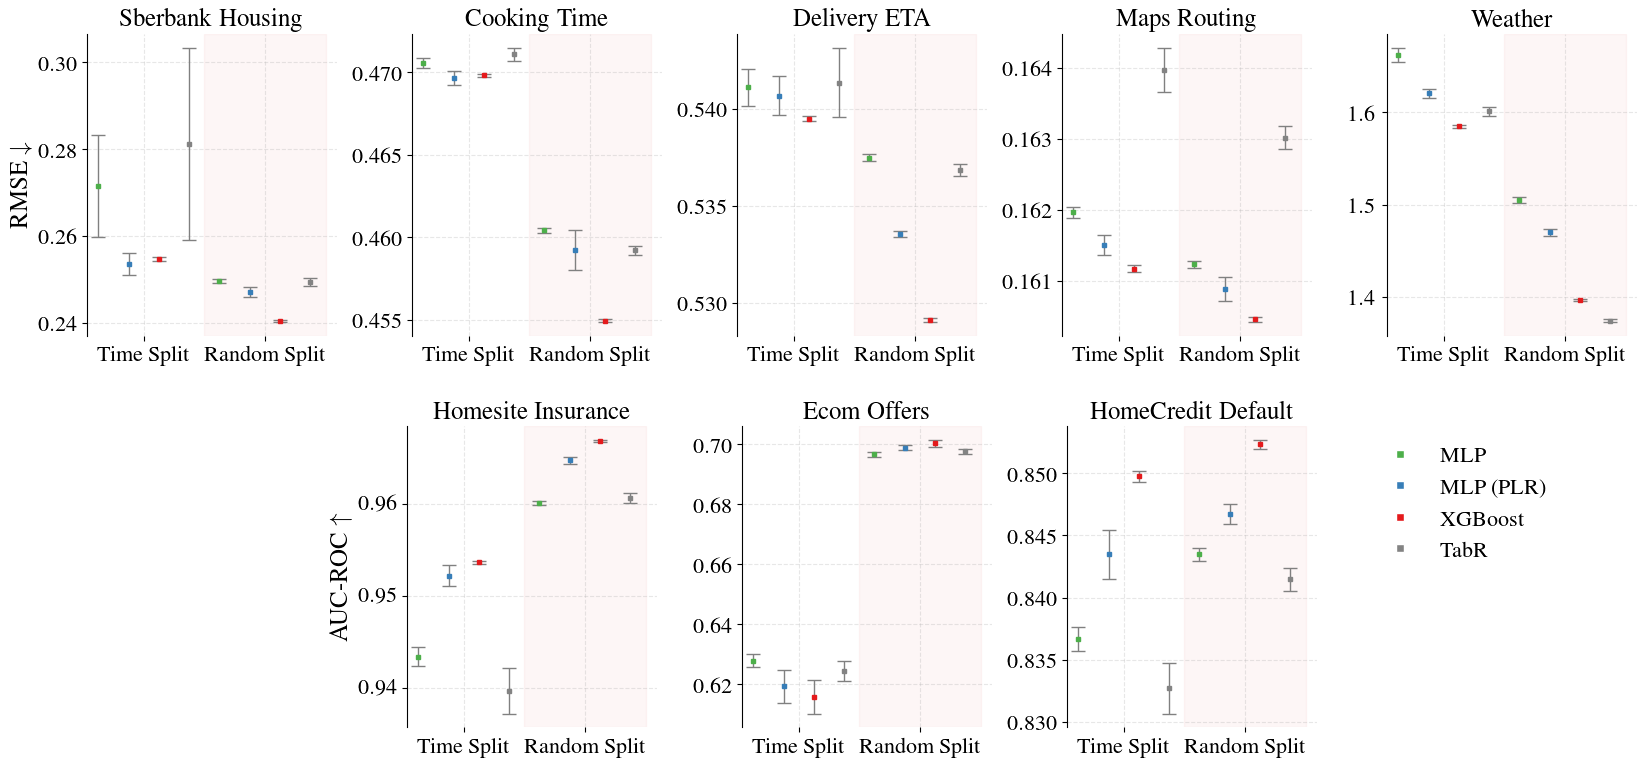

In [158]:
# The Plot

fig = plt.figure(figsize=(20, 9))
# c1, c2, c3, c4 = , '#377EB8', '#E41A1C', '#838383'

colors = {
    'mlp': '#4DAF4A', 
    'mlp-plr': '#377EB8',
    'xgboost_': '#E41A1C',
    'tabr': '#838383',
}

for i, d in enumerate(datasets):
    ax = plt.subplot(2, 5, i+1)

    plot_data = []
    for split in ["sliding-window", "random"]:
        for j, m in enumerate(["mlp", "mlp-plr", "xgboost_", "tabr"]):
            # This is to plot many boxplots at once
            # for split_idx in range(1):
            # plot_data.append(list(s.filter(
            #     pl.col('data').eq(d),
            #     pl.col('model').eq(m),
            #     pl.col('split').eq(split),
            #     # For multiple boxplots
            #     # pl.col('split-idx').eq(split_idx),
            # )['score'].item()))

            d_ = s.filter(
                pl.col('data').eq(d),
                pl.col('model').eq(m),
                pl.col('split').eq(split),
            )

            # Errorbars
            ax.errorbar(
                j + (4 if split == 'random' else 0), d_['score'].item(), d_['score_std'].item(), 
                marker='s',
                ms=3.5,
                ecolor='gray',
                elinewidth=1,
                mfc=colors[m],
                mec=colors[m],
                # label=m if split == "sliding-window" else None,
                capsize=5
            )



    # bplot = ax.boxplot(plot_data, False, '', patch_artist=True)

    # for i in range(8):
    #     bplot['medians'][i].set_color('#000000')
    #     bplot['medians'][i].set_linewidth(0.5)

    # Plot many boxplots
    # ax.axvspan(4.5*2, 8.5*2, color='#e41a1c', alpha=0.04)

    # Plot one boxplot forall
    ax.axvspan(3.5, 7.5, color='#e41a1c', alpha=0.04)
    # bplot['boxes'][0].set_color(c1)
    # bplot['boxes'][0].set_label('MLP')
    # bplot['boxes'][1].set_color(c2)
    # bplot['boxes'][1].set_label('MLP-PLR')
    # bplot['boxes'][2].set_color(c3)
    # bplot['boxes'][2].set_label('XGBoost')
    # bplot['boxes'][3].set_color(c4)
    # bplot['boxes'][3].set_label('TabR')
    # bplot['boxes'][4].set_color(c1)
    # bplot['boxes'][5].set_color(c2)
    # bplot['boxes'][6].set_color(c3)
    # bplot['boxes'][7].set_color(c4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Average boxplot
    plt.xticks([1.5, 5.5], ['Time Split', 'Random Split'])
    
    # Many boxplots
    # plt.xticks([2.5*2, 6.5*2], ['Time Split', 'Random Split'])

    plt.tick_params(labelsize=16)
    ax.set_title(dataset_name[d], fontsize=18)
    ax.grid(which='both', linestyle='--', alpha=0.3)

    if d == 'sberbank-housing':
        ax.set_ylabel(r'RMSE $\downarrow$', fontsize=18)
    elif d == 'homesite-insurance':
        ax.set_ylabel(r'AUC-ROC $\uparrow$', fontsize=18)

    if d == 'homecredit-default':
        plt.legend(
            handles=[
                Line2D(
                    [0],[0], 
                    marker='s', color='w', label=model_name[m],
                    markerfacecolor=colors[m], markersize=6
                ) for m in ['mlp', 'mlp-plr', 'xgboost_', 'tabr']
            ],
            loc='upper right', bbox_to_anchor=(2, 1.0), fontsize=16, edgecolor='#ffffff'
        )


fig.subplots_adjust(wspace=0.3, hspace=0.3)

#.set_positions()

shift = 0.16
p = fig.axes[-3].get_position()
p.x0 += shift
p.x1 += shift
fig.axes[-3].set_position(p)

shift = 0.165
p = fig.axes[-2].get_position()
p.x0 += shift
p.x1 += shift
fig.axes[-2].set_position(p)

shift = 0.165
p = fig.axes[-1].get_position()
p.x0 += shift
p.x1 += shift
fig.axes[-1].set_position(p)

plt.savefig('figure-id-ood.pdf', bbox_inches='tight')
plt.show()